# Need to run automatic lfilter as pbs job

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.cm.get_cmap("gist_earth")
from datetime import timedelta
import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client



def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()


/jobfs/110695799.gadi-pbs/ipykernel_1990165/53852169.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  earth_cmap = matplotlib.cm.get_cmap("gist_earth")
sh: None: command not found
INFO: Compiled ParcelsRandom ==> /jobfs/110695799.gadi-pbs/parcels-16078/libparcels_random_028b4429-147d-4a3a-bfc2-7312f83a91e8.so
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38747 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:39047' processes=7 threads=28, memory=112.00 GiB>


## Steps:

1. Recipes function calls this script, passing: `zlevels`, `expt`, `t0`, `time_window`,`filter_window`,`filter_cutoff`
2. Make a folder if not exists in the postprocessing folder. Name it after t0. Might also need to make a csv file to keep track of which t0's are eddy vs no eddy? Then label the outputs accordingly
3. Spawn a new pbs job for each z level on 28bw cores as normal. Each script generates a `filtered_0x.nc` file. 
4. Postprocess within each pbs job. Read back in the `filtered_0x.nc` file and restore the attributes *including* the z level.

Could design the function to be recursive, and only do steps 1&2 if qsub = False? 

## First read in a single that overlaps the eddy

In [2]:

def lagrange_filter(expt,zl,t0,time_window = 200,filter_window = 100,filter_cutoff = 2*np.pi/(12.42*3600)):
    """
    Apply the Lagrange filter to the input data. This is a wrapper around the LagrangeFilter class in filtering.py
    Saves the outputs to `postprocessing/expt/lfiltered/t0-<t0>/filtered_<zl>.nc` with a separate file for each z level.
    """
    client = startdask()
    tmpstorage = os.getenv('PBS_JOBFS')

    rawdata = tt.collect_data(
        expt,
        rawdata = ["u","v"],
        timerange=(t0 - time_window,t0 + time_window)).isel(zl = [zl])

    # Save attributes to re-add later
    attrs = {
        "u": rawdata.u.attrs,
        "v": rawdata.v.attrs,
        "time": rawdata.time.attrs,
        "xb": rawdata.xb.attrs,
        "yb": rawdata.yb.attrs,
        "zl": rawdata.zl.attrs,
        "base" : rawdata.attrs
    }

    ## Save z level to re-add later
    zl_value = rawdata.zl.values[0]

    ## Remove zl to make data properly 2D
    rawdata = rawdata.isel(zl = 0)

    # Strip attrs since lagrange filter complains about them
    rawdata.u.attrs = {}
    rawdata.v.attrs = {}
    rawdata.zl.attrs = {}
    rawdata.time.attrs = {}
    rawdata.yb.attrs = {}
    rawdata.xb.attrs = {}
    rawdata = rawdata.assign_coords({
        "time":rawdata.time * 3600,
        "xb":rawdata.xb * 1000,
        "yb":rawdata.yb * 1000})
    # rawdata = rawdata.drop(["bathy","lat","lon"]) ## COMMENTED OUT FOR NOTIDE

    print("Saving data to temporary storage")

    rawdata.u.to_netcdf(tmpstorage + f"/u.nc",mode="w")
    rawdata.v.to_netcdf(tmpstorage + f"/v.nc",mode="w")
    (rawdata.v**2).rename("vv").to_netcdf(tmpstorage + f"/vv.nc",mode="w")
    (rawdata.u**2).rename("uu").to_netcdf(tmpstorage + f"/uu.nc",mode="w")
    (rawdata.u*rawdata.v).rename("uv").to_netcdf(tmpstorage + f"/uv.nc",mode="w")
    print("done")
    client.close()

    if os.path.exists(tmpstorage + "/filtered.nc"):
        os.remove(tmpstorage + "/filtered.nc")
    f = filtering.LagrangeFilter(
        tmpstorage + "/filtered", ## Save intermediate output to temporary storage
        {
            "U":tmpstorage + "/u.nc",
            "V":tmpstorage + "/v.nc",
            "uu":tmpstorage + "/uu.nc",
            "vv":tmpstorage + "/vv.nc",
            "uv":tmpstorage + "/uv.nc"
        }, 
        {"U":"u","V":"v","uu":"uu","vv":"vv","uv":"uv"}, 
        {"lon":"xb","lat":"yb","time":"time"},
        sample_variables=["U","V","vv","uu","uv"], mesh="flat",highpass_frequency = filter_cutoff,
        advection_dt =timedelta(minutes=5).total_seconds(),
        window_size = timedelta(hours=48).total_seconds(),
    )
    f(times = range(3600 * (time_window - filter_window),3600 * (time_window + filter_window),3600)) ## Ensure we take times either side of the point of interest

    ## Remove stored data to save space on disk
    for i in ["u","v","uu","vv","uv"]:
        os.remove(tmpstorage + f"/{i}.nc")

    client = startdask()

    ## Load the filtered data
    filtered = xr.open_dataset(tmpstorage + "/filtered.nc",chunks = "auto")

    ## Re-add zl as a dimension. Expand dims, then add zl
    filtered = filtered.expand_dims({"zl":[zl_value]})

    ## Restore scale and attributes of rawdata
    filtered = filtered.assign_coords({
        "time":filtered.time / 3600,
        "xb":filtered.xb / 1000,
        "yb":filtered.yb / 1000})

    ## Fix up names of filtered variables:
    for i in filtered.data_vars:
        filtered = filtered.rename({i:i.split("_")[1].lower()})

    filtered.attrs = attrs["base"]
    filtered.u.attrs = attrs["u"]
    filtered.v.attrs = attrs["v"]
    filtered.zl.attrs = attrs["zl"]
    filtered.time.attrs = attrs["time"]
    filtered.yb.attrs = attrs["yb"]
    filtered.xb.attrs = attrs["xb"]

    filtered.attrs["long_name"] = "Filtered velocity data"

    cst = cross_scale_transfer(filtered)

    filtered["cst"] = cst

    ## Now save to the postprocessing file. 

    outfolder = Path(f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/20hr_cutoff/")

    if not os.path.exists(outfolder):
        os.makedirs(outfolder)


    filtered[["u","v","cst","uu","vv","uv"]].to_netcdf(outfolder / f"filtered.nc",mode="w")
def cross_scale_transfer(data):

    tau_uu = data.uu - data.u**2
    tau_uv = data.uv - data.u*data.v
    tau_vv = data.vv - data.v**2
    u = data.u
    v = data.v
    uu = data.uu
    vv = data.vv

    transfer = (
        tau_uu * u.differentiate("xb") +
        tau_uv * u.differentiate("yb") +
        tau_uv * v.differentiate("xb") +
        tau_vv * v.differentiate("yb")
    ).rename("energy_transfer")

    return transfer

def plot_transfer(data,vmax = 1.):
    """
    data needs to contain bathy, energy transfer, b"""
    cmap = matplotlib.cm.get_cmap("RdBu")
    fig,ax = plt.subplots(2,figsize = (15,12))
    # Set the background colour to the plot to the lowest value in the cmap
    ax[0].set_facecolor("white")
    ax[1].set_facecolor("white")
    
    if type(vmax) == float or type(vmax) == int:
        data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,vmax = vmax,vmin = -vmax,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    else:
        data.energy_transfer.plot(ax = ax[0],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Energy transfer (m^2/s^3)"})
    data.vorticity.plot(ax = ax[1],cmap = cmap,add_colorbar = True,cbar_kwargs={'label': "Vorticity"},vmax = 0.1,vmin = -0.1)

    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[0],add_colorbar = False)
    data.bathy.plot(cmap = earth_cmap,vmin = -1000,vmax = 1500,ax = ax[1],add_colorbar = False)

    ax[0].set_xlabel("")
    ax[0].set_title(f"Energy transfer from small to larger scales")
    ax[1].set_title(f"Vorticity")
    plt.show()
    return fig

    

In [25]:
lagrange_filter("full-20",5,44900,time_window = 50,filter_window = 1,filter_cutoff = 2*np.pi/(20*3600))


<Client: 'tcp://127.0.0.1:45357' processes=7 threads=28, memory=112.00 GiB>
loading u...	done.
loading v...	done.
Saving data to temporary storage
done
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0


sh: None: command not found
INFO: Compiled SamplingParticlesample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/db5383f65eceb1c21914dba5203cbc6e_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticlesample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/db5383f65eceb1c21914dba5203cbc6e_0.so
sh: None: command not found
INFO: Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/712e1ea086419d1117dcf775d957108c_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/712e1ea086419d1117dcf775d957108c_0.so
INFO: Temporary output files are stored in /home/149/ab8992/tmp5b1wlec9.h5.
INFO:parcels.tools.loggers:Temporary output files are stored in /home/149/ab8992/tmp5b1wlec9.h5.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmp5b1wlec9.h5" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir

<Client: 'tcp://127.0.0.1:42937' processes=7 threads=28, memory=112.00 GiB>


In [28]:
lagrange_filter("notide-20",5,38000,time_window = 50,filter_window = 1,filter_cutoff = 2*np.pi/(20*3600))


<Client: 'tcp://127.0.0.1:42937' processes=7 threads=28, memory=112.00 GiB>
loading u...	done.
loading v...	done.
Saving data to temporary storage
done
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0
0.3.0


sh: None: command not found
INFO: Compiled SamplingParticlesample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/407ceade36086782eeea80e16a505bda_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticlesample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/407ceade36086782eeea80e16a505bda_0.so
sh: None: command not found
INFO: Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/977e1b47271660e869fe6589362d1aec_0.so
INFO:parcels.tools.loggers:Compiled SamplingParticleAdvectionRK4sample_kernel ==> /jobfs/110695799.gadi-pbs/parcels-16078/977e1b47271660e869fe6589362d1aec_0.so
INFO: Temporary output files are stored in /home/149/ab8992/tmpe_aljpj2.h5.
INFO:parcels.tools.loggers:Temporary output files are stored in /home/149/ab8992/tmpe_aljpj2.h5.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/149/ab8992/tmpe_aljpj2.h5" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir

<Client: 'tcp://127.0.0.1:37355' processes=7 threads=28, memory=112.00 GiB>


## Plot the tests

0.3.0
loading u...	done.
loading v...	done.


/jobfs/110695799.gadi-pbs/ipykernel_1990165/3502434353.py:20: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vorticity = tt.calculate_vorticity(rawdata_tide.drop("time")).rename("vorticity")
/jobfs/110695799.gadi-pbs/ipykernel_1990165/2133052957.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


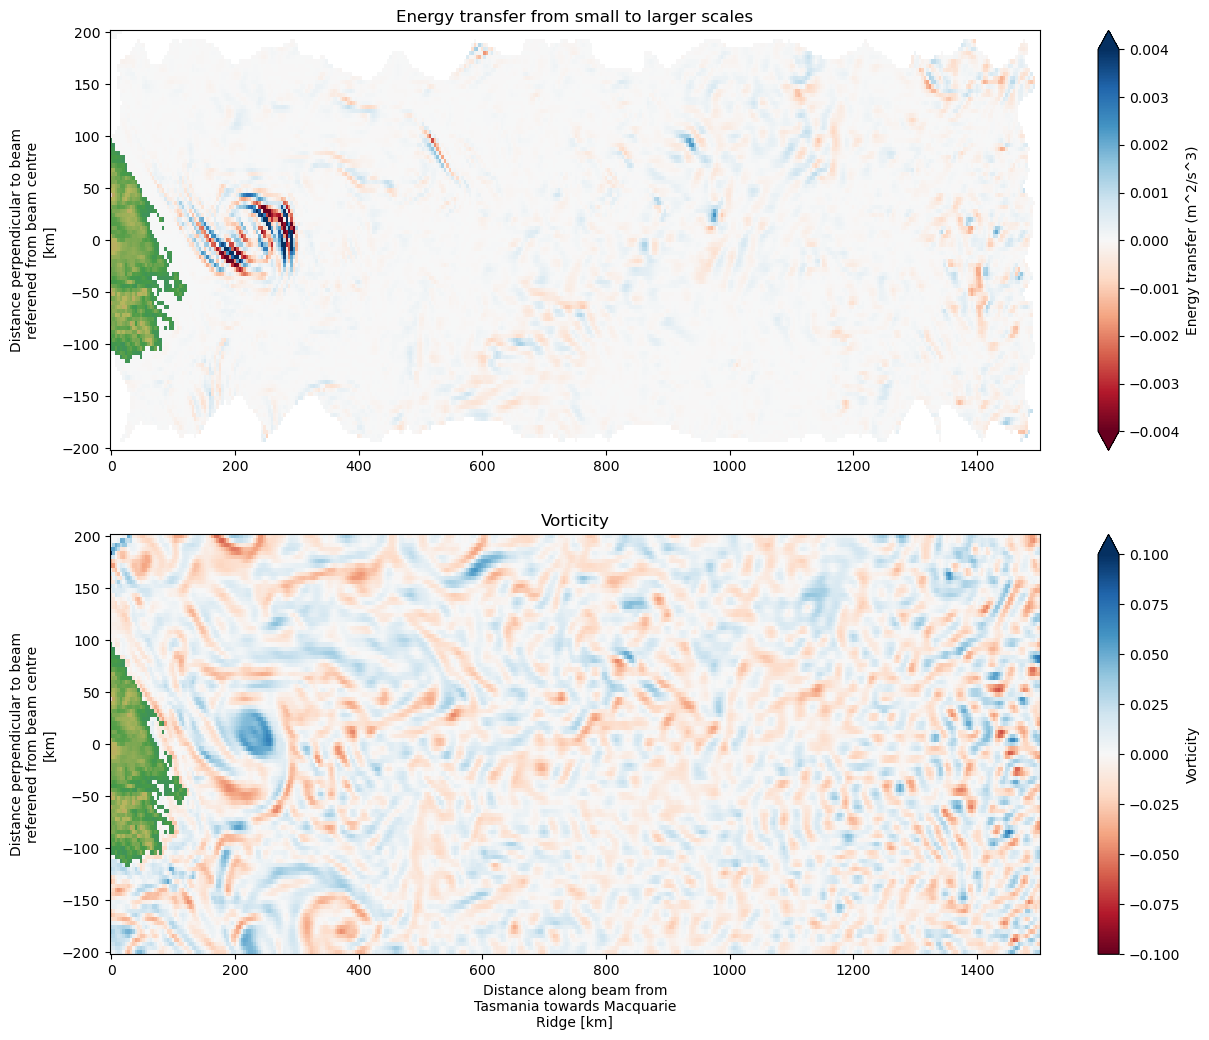

In [3]:
expt = "full-20"

bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").elevation
bathy = bathy.where(bathy > 0).rename("bathy").drop_vars("lon").drop_vars("lat")

time_window = 200 # How many hours either side of t0 to consider
filter_window = 100 # How many hours either side of t0 to actually filter (subset of time window)


t0 = 44900 # Time in the middle of the window to be filtered
expt = "full-20"
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/dt_5min"
rawdata_tide = tt.collect_data(
    expt,
    rawdata = ["u","v"],
    timerange=(t0 - filter_window,t0 + filter_window)).isel(zl = 2,time = 100)


cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).isel(time = 0).cst.rename("energy_transfer").persist()
vorticity = tt.calculate_vorticity(rawdata_tide.drop("time")).rename("vorticity")
merged = xr.merge([cst,bathy,vorticity]).load()

fig = plot_transfer(merged.isel(zl = 0),vmax = 0.004)


loading u...	done.
loading v...	done.


/jobfs/110695799.gadi-pbs/ipykernel_1990165/2410526592.py:19: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vorticity = tt.calculate_vorticity(rawdata_tide.drop("time")).rename("vorticity")
/jobfs/110695799.gadi-pbs/ipykernel_1990165/2133052957.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("RdBu")


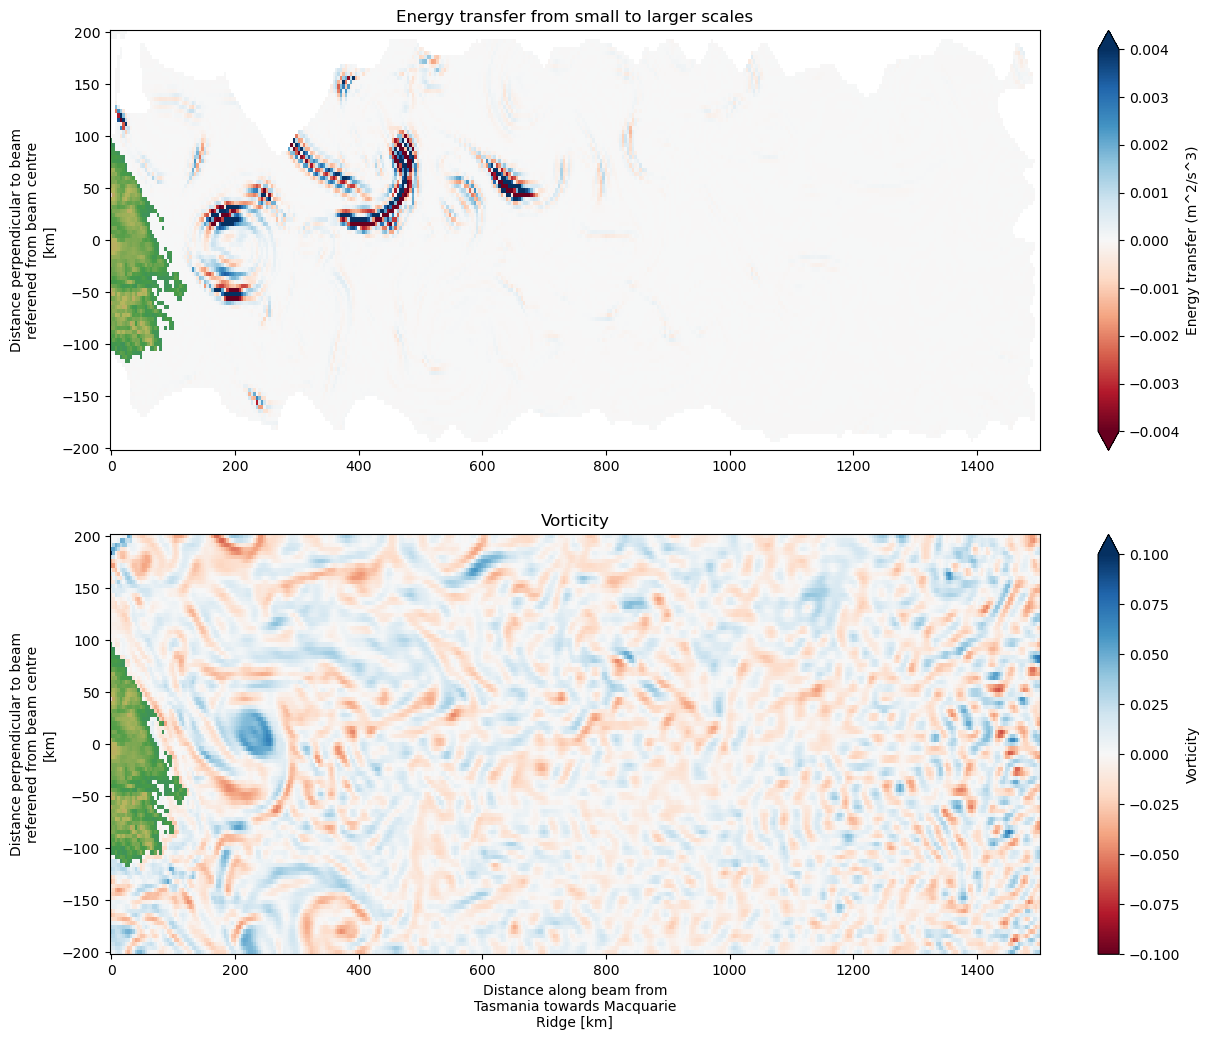

In [4]:
expt = "notide-20"

bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").elevation
bathy = bathy.where(bathy > 0).rename("bathy").drop_vars("lon").drop_vars("lat")

time_window = 200 # How many hours either side of t0 to consider
filter_window = 100 # How many hours either side of t0 to actually filter (subset of time window)


t0 = 38000 # Time in the middle of the window to be filtered
outpath = f"/g/data/nm03/ab8992/postprocessed/{expt}/lfiltered/dt_5min"
rawdata_notide = tt.collect_data(
    expt,
    rawdata = ["u","v"],
    timerange=(t0 - filter_window,t0 + filter_window)).isel(zl = 2,time = 100)


cst = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).isel(time = 0).cst.rename("energy_transfer").persist()
vorticity = tt.calculate_vorticity(rawdata_notide.drop("time")).rename("vorticity")
merged = xr.merge([cst,bathy,vorticity]).load()

fig = plot_transfer(merged.isel(zl = 0),vmax = 0.004)


# Check the velocities only

0.3.0


Text(0.5, 0, '')

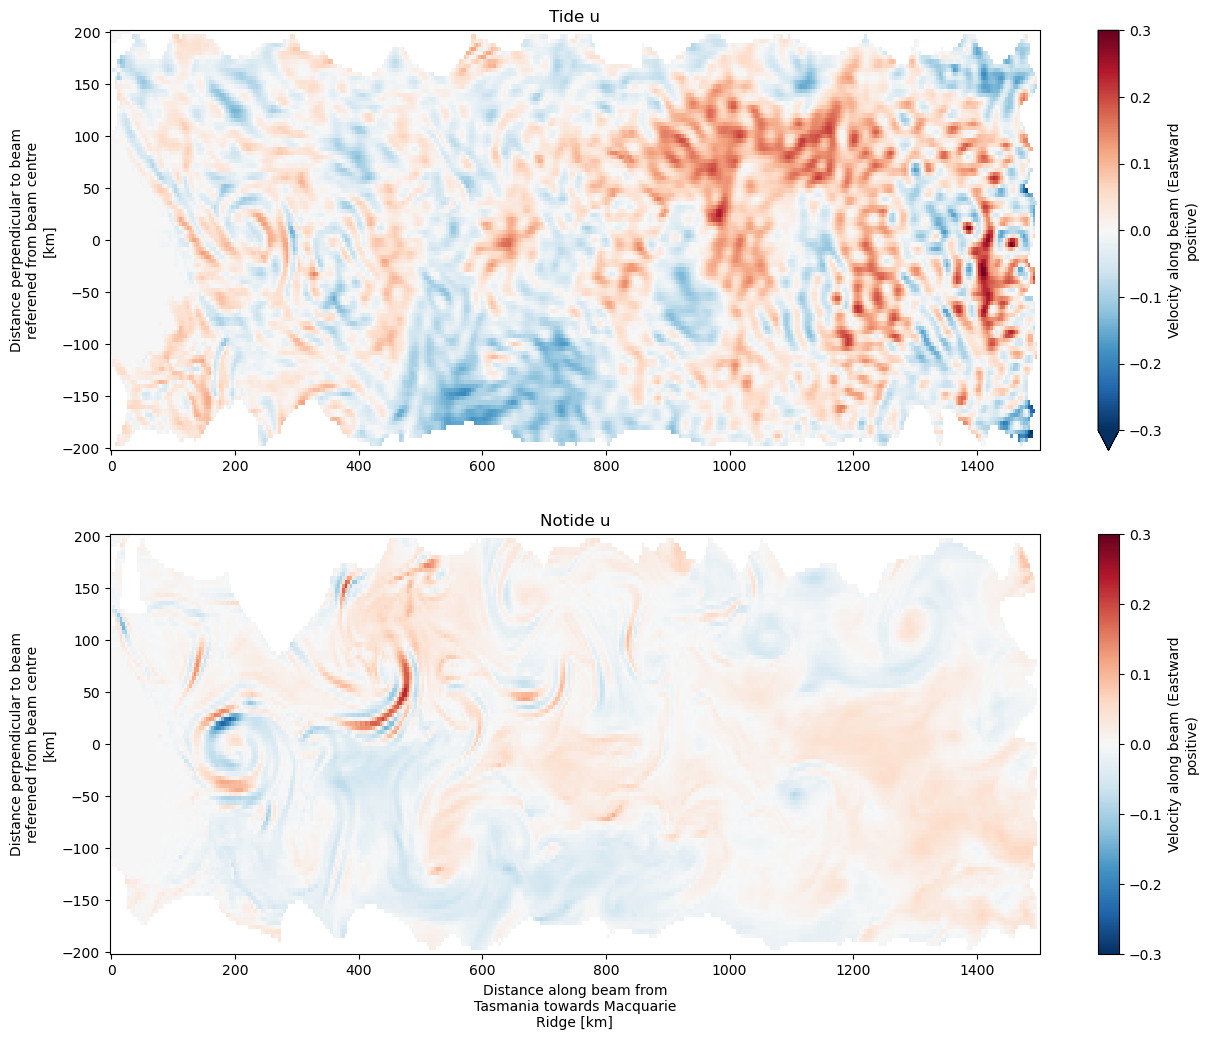

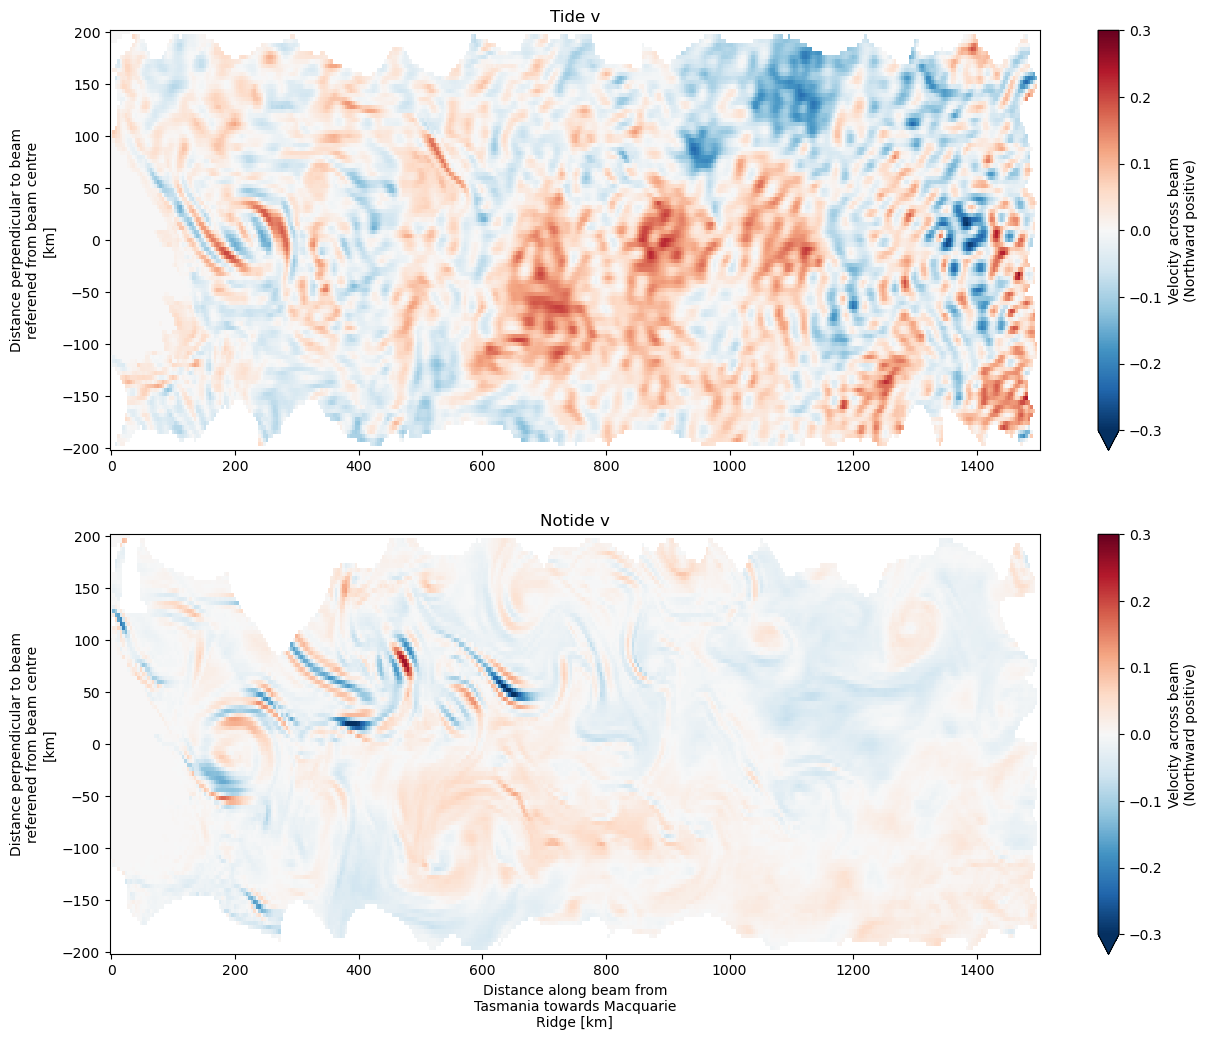

In [3]:
outpath = f"/g/data/nm03/ab8992/postprocessed/full-20/lfiltered/dt_5min"
tide = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).isel(time = 0)

outpath = f"/g/data/nm03/ab8992/postprocessed/notide-20/lfiltered/dt_5min"
notide = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).isel(time = 0)


fig,ax = plt.subplots(2,figsize = (15,12))
tide.u.plot(ax = ax[0],vmax = 0.3,vmin = -0.3,cmap = "RdBu_r")
notide.u.plot(ax = ax[1],vmax = 0.3,vmin = -0.3,cmap = "RdBu_r")
ax[0].set_title("Tide u")
ax[1].set_title("Notide u")
ax[0].set_xlabel("")

fig,ax = plt.subplots(2,figsize = (15,12))
tide.v.plot(ax = ax[0],vmax = 0.3,vmin = -0.3,cmap = "RdBu_r")
notide.v.plot(ax = ax[1],vmax = 0.3,vmin = -0.3,cmap = "RdBu_r")
ax[0].set_title("Tide v")
ax[1].set_title("Notide v")
ax[0].set_xlabel("")


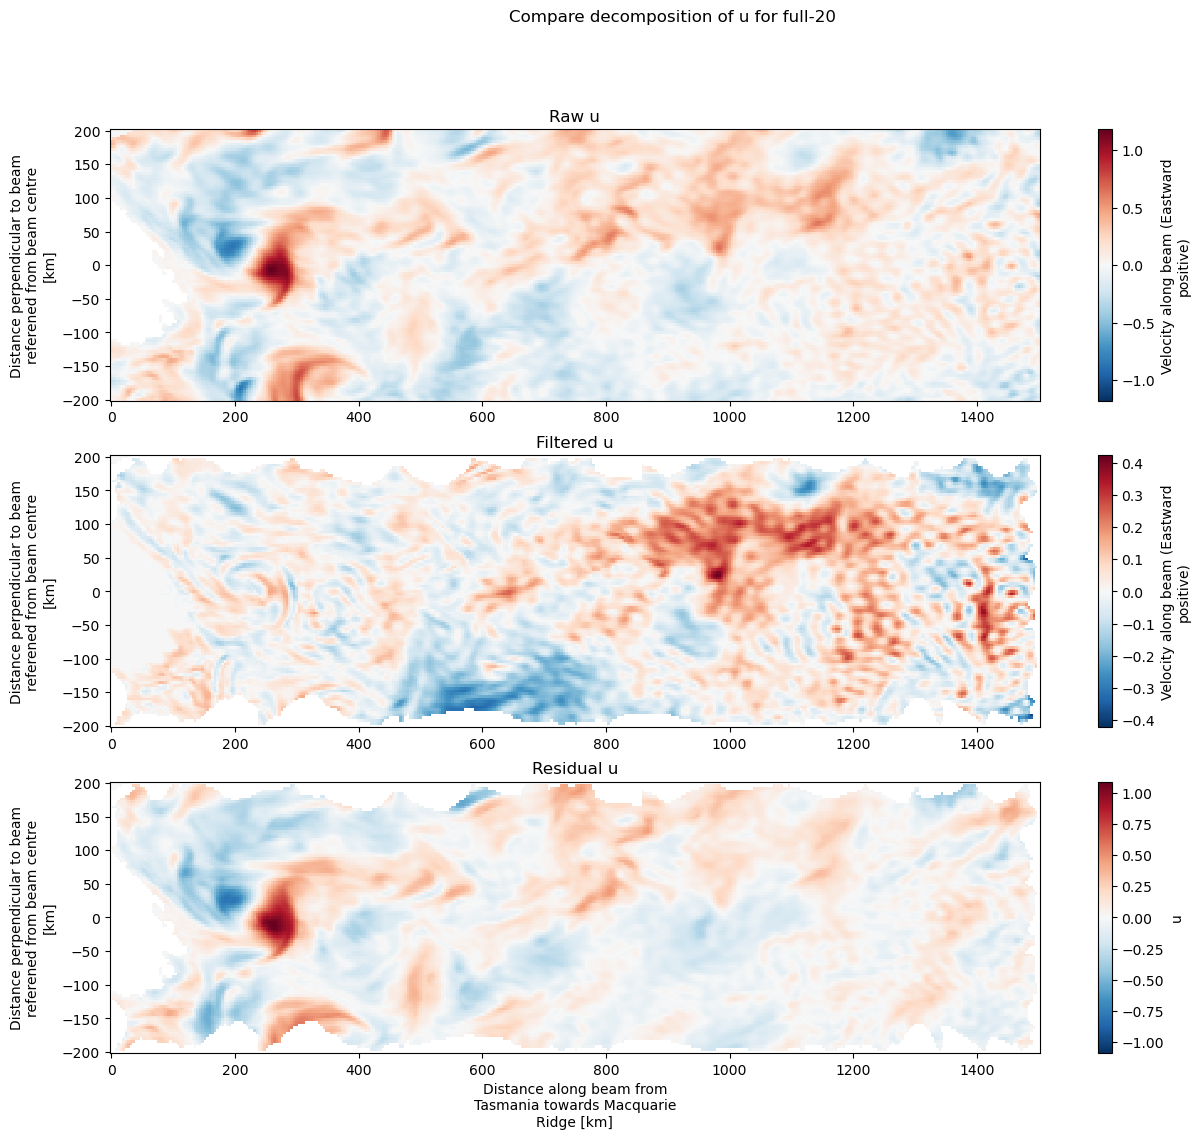

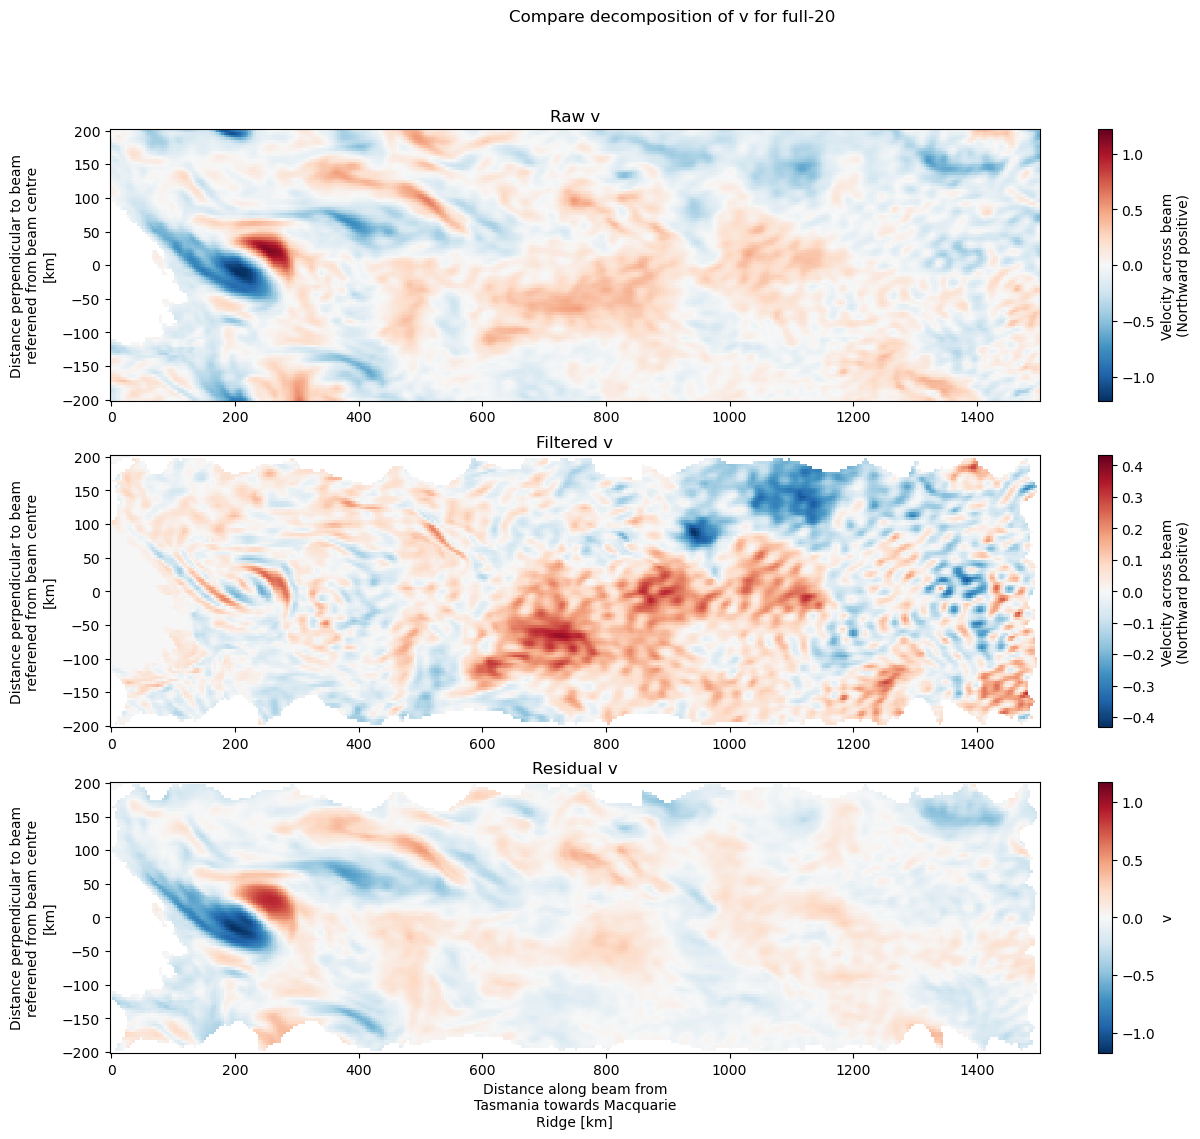

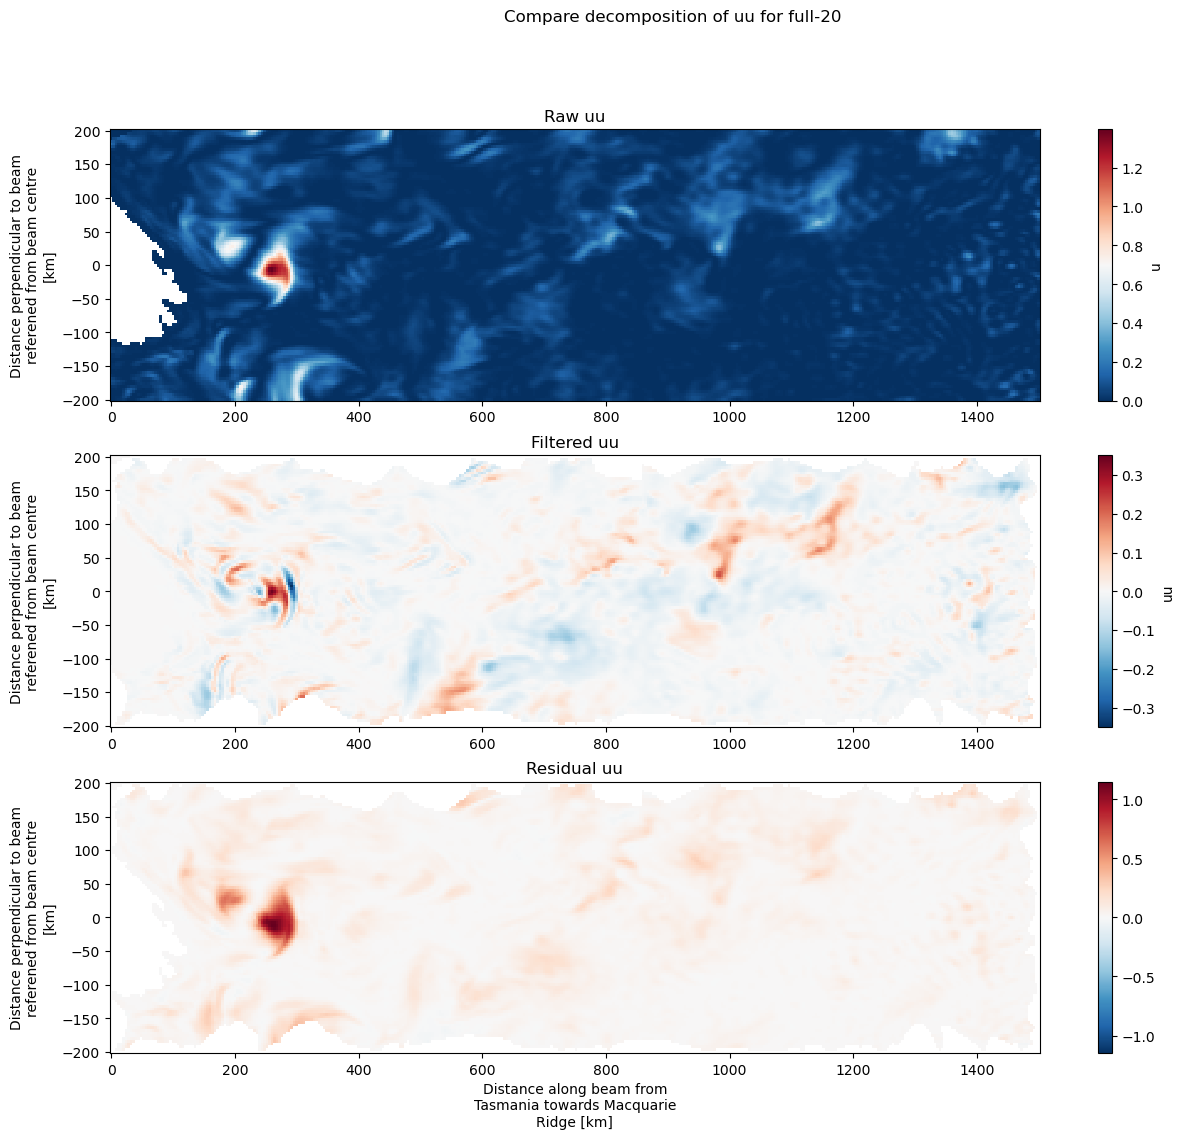

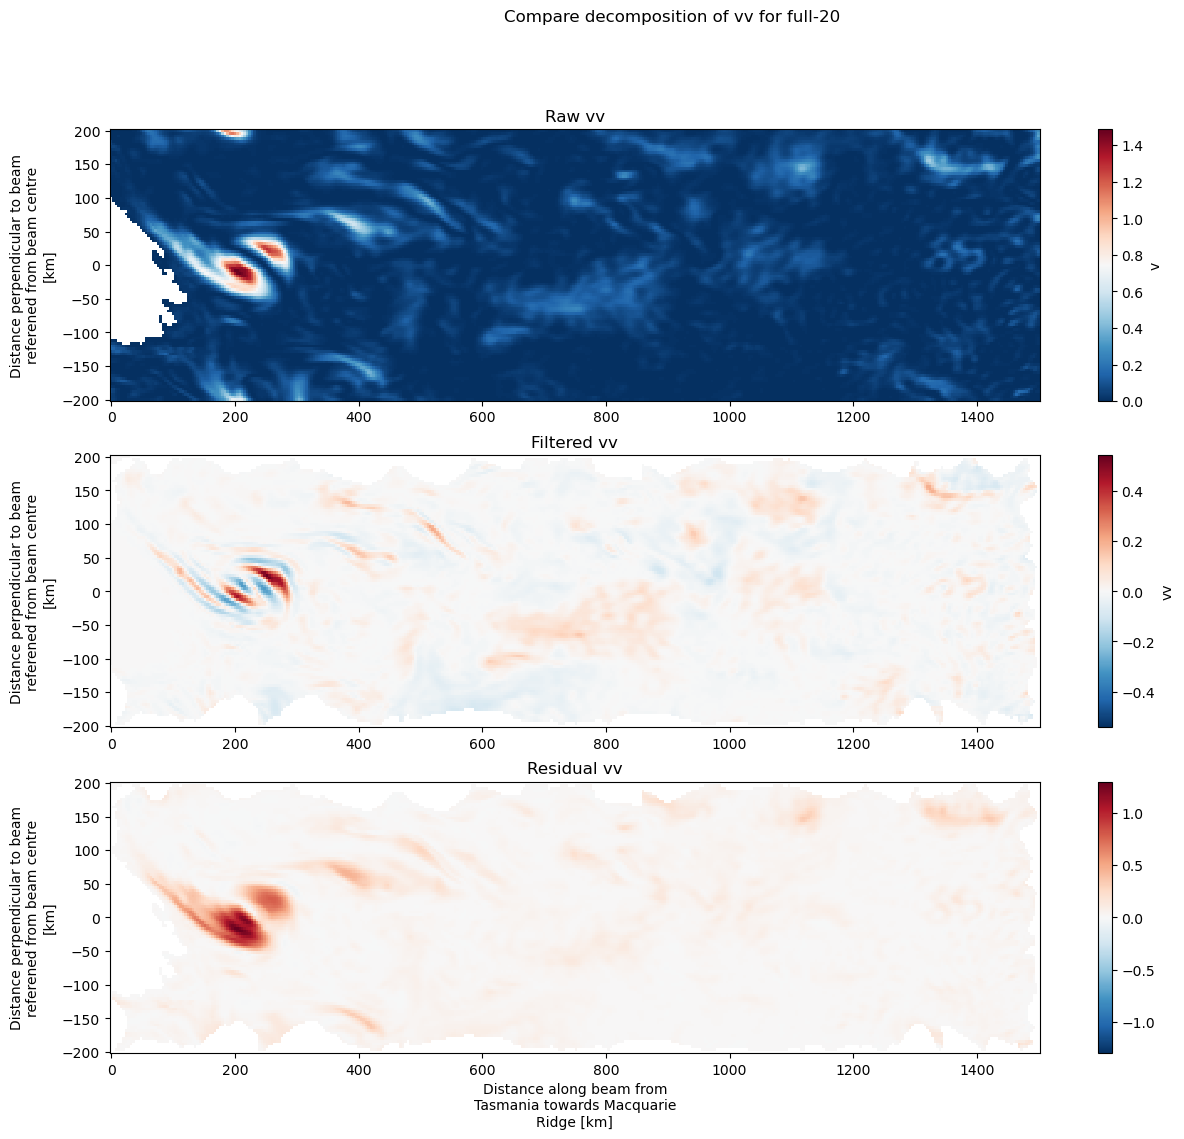

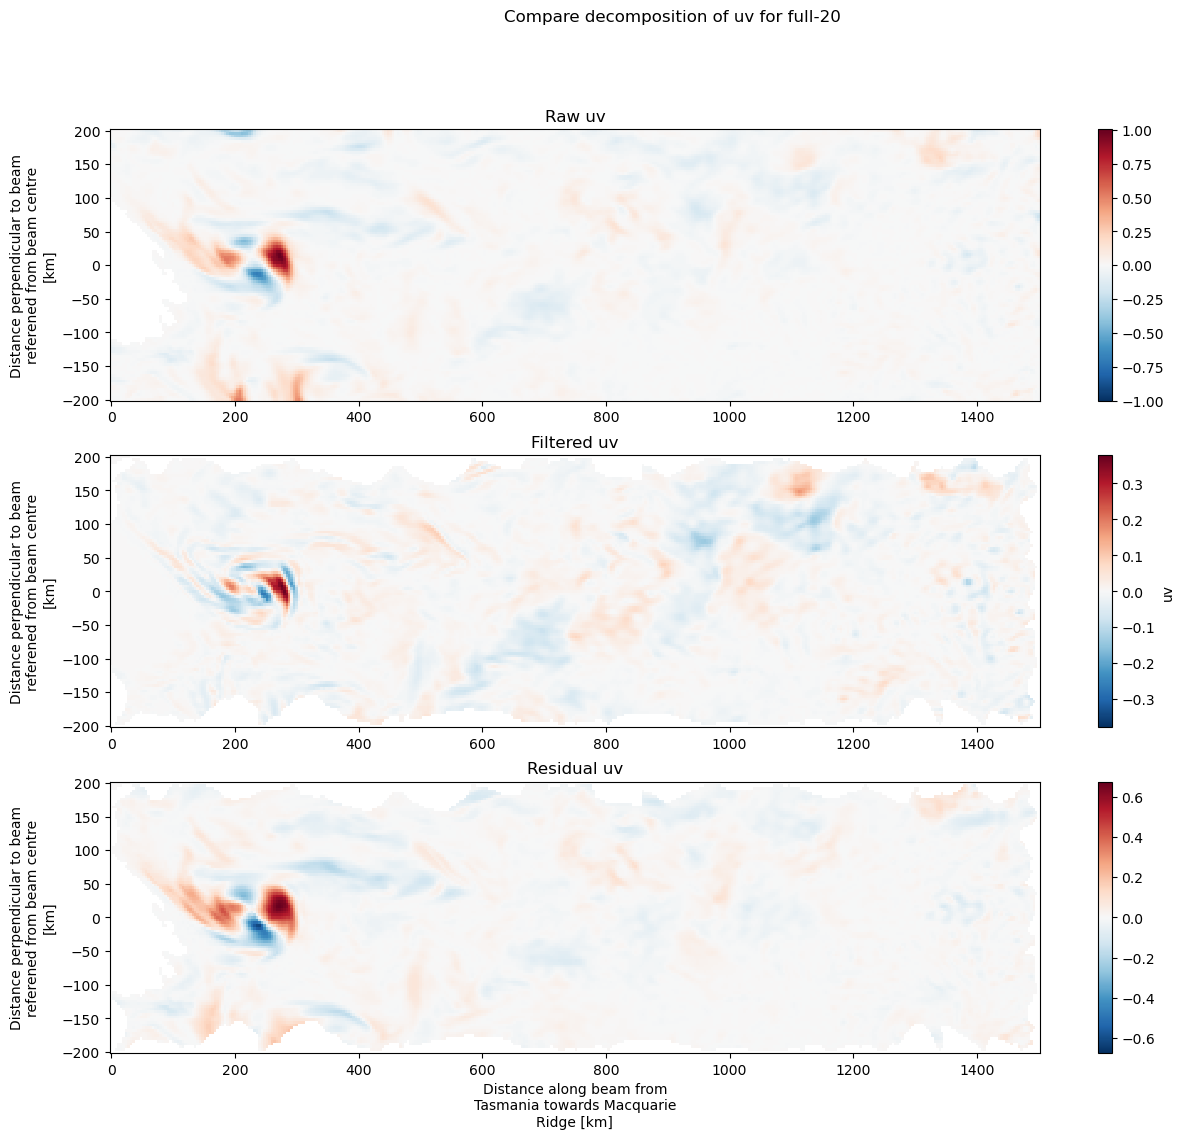

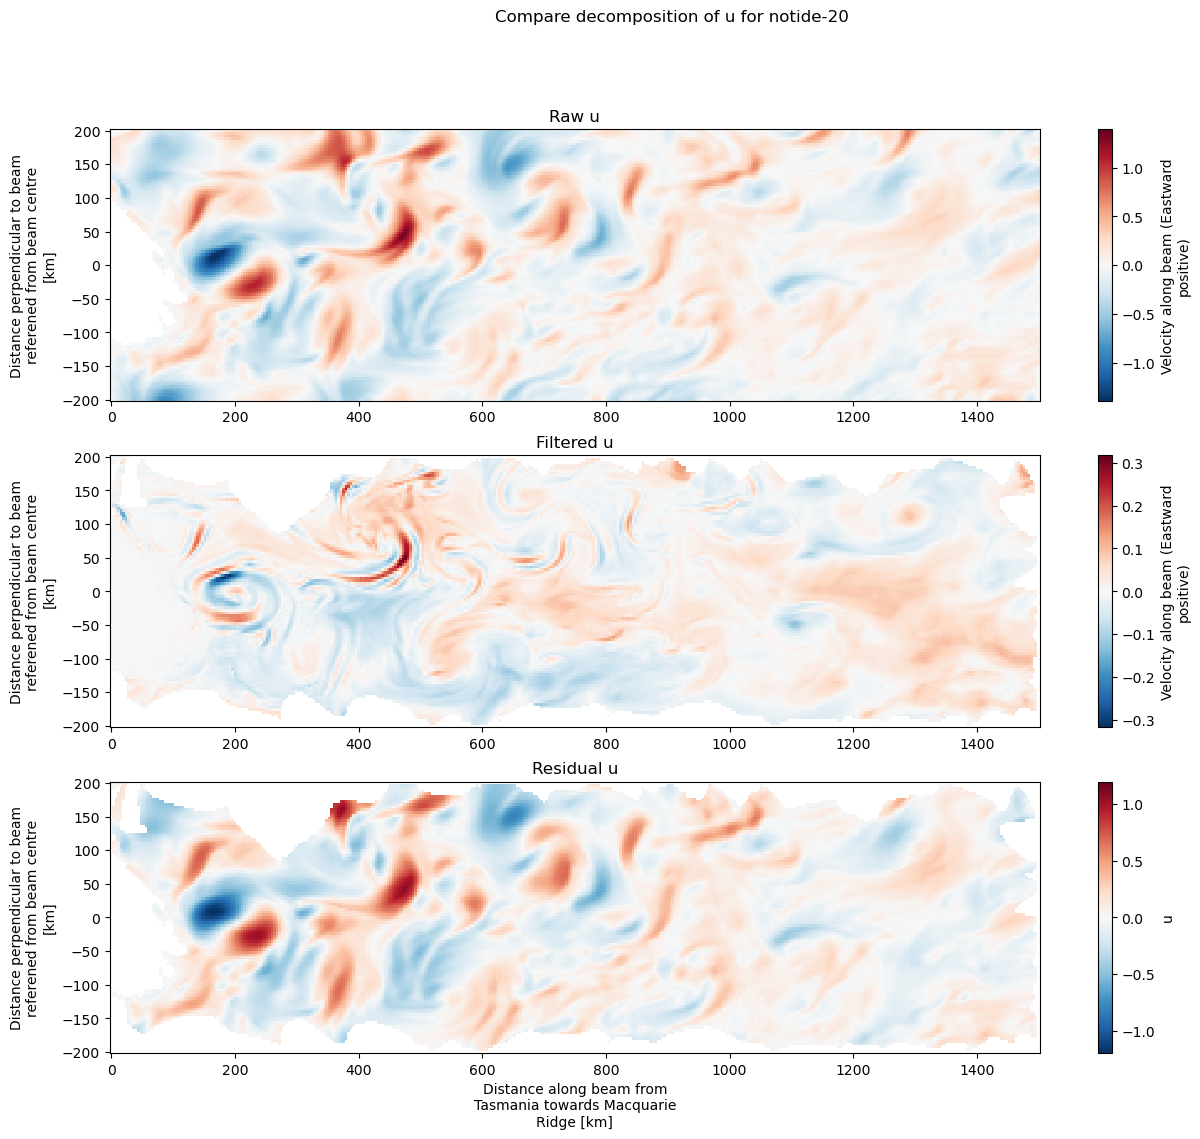

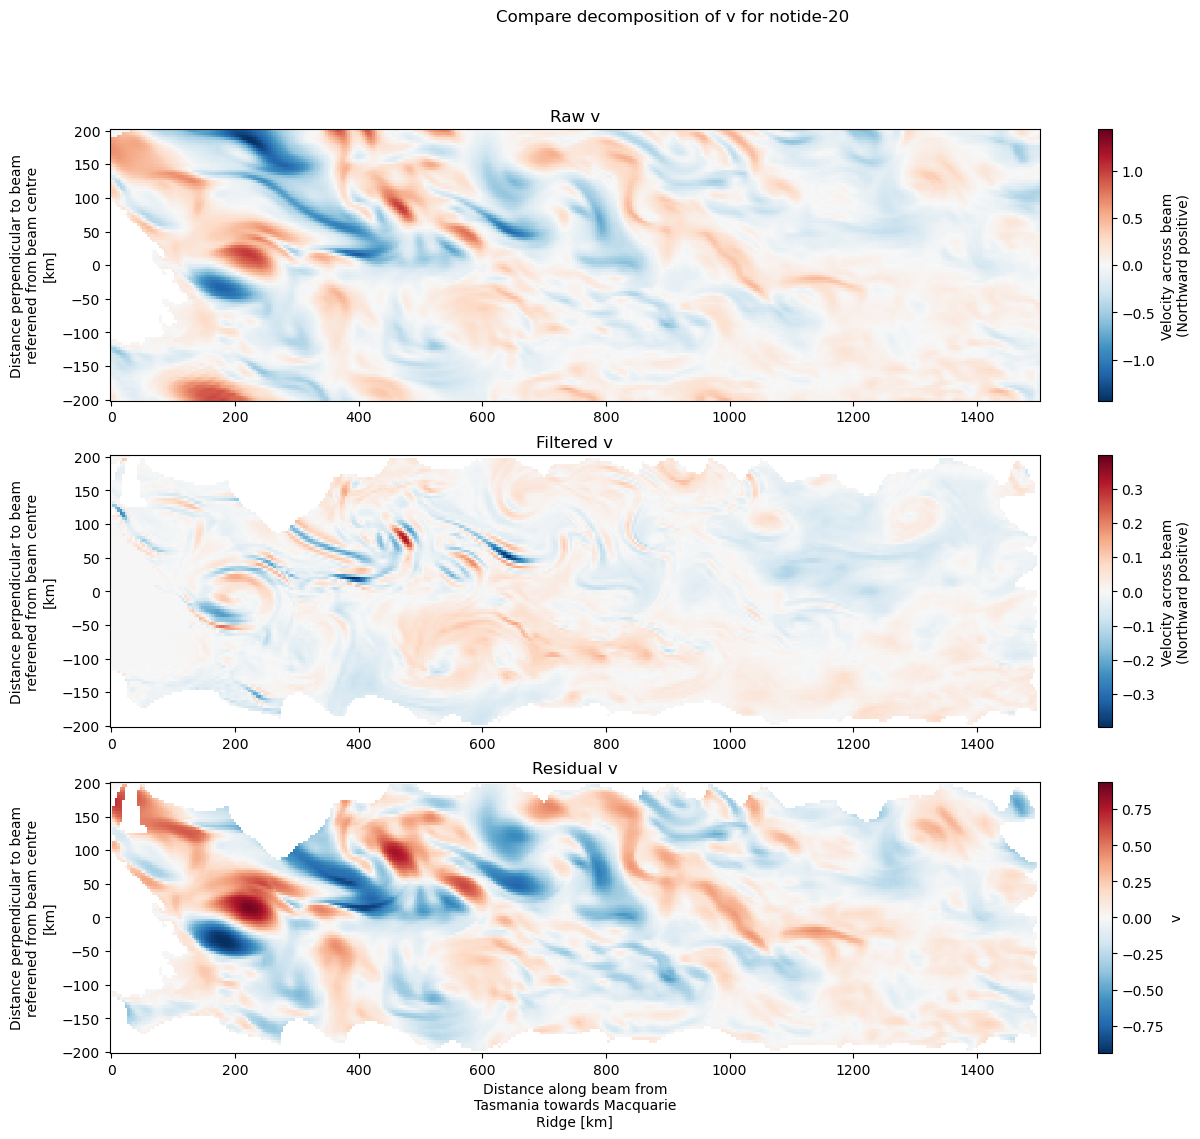

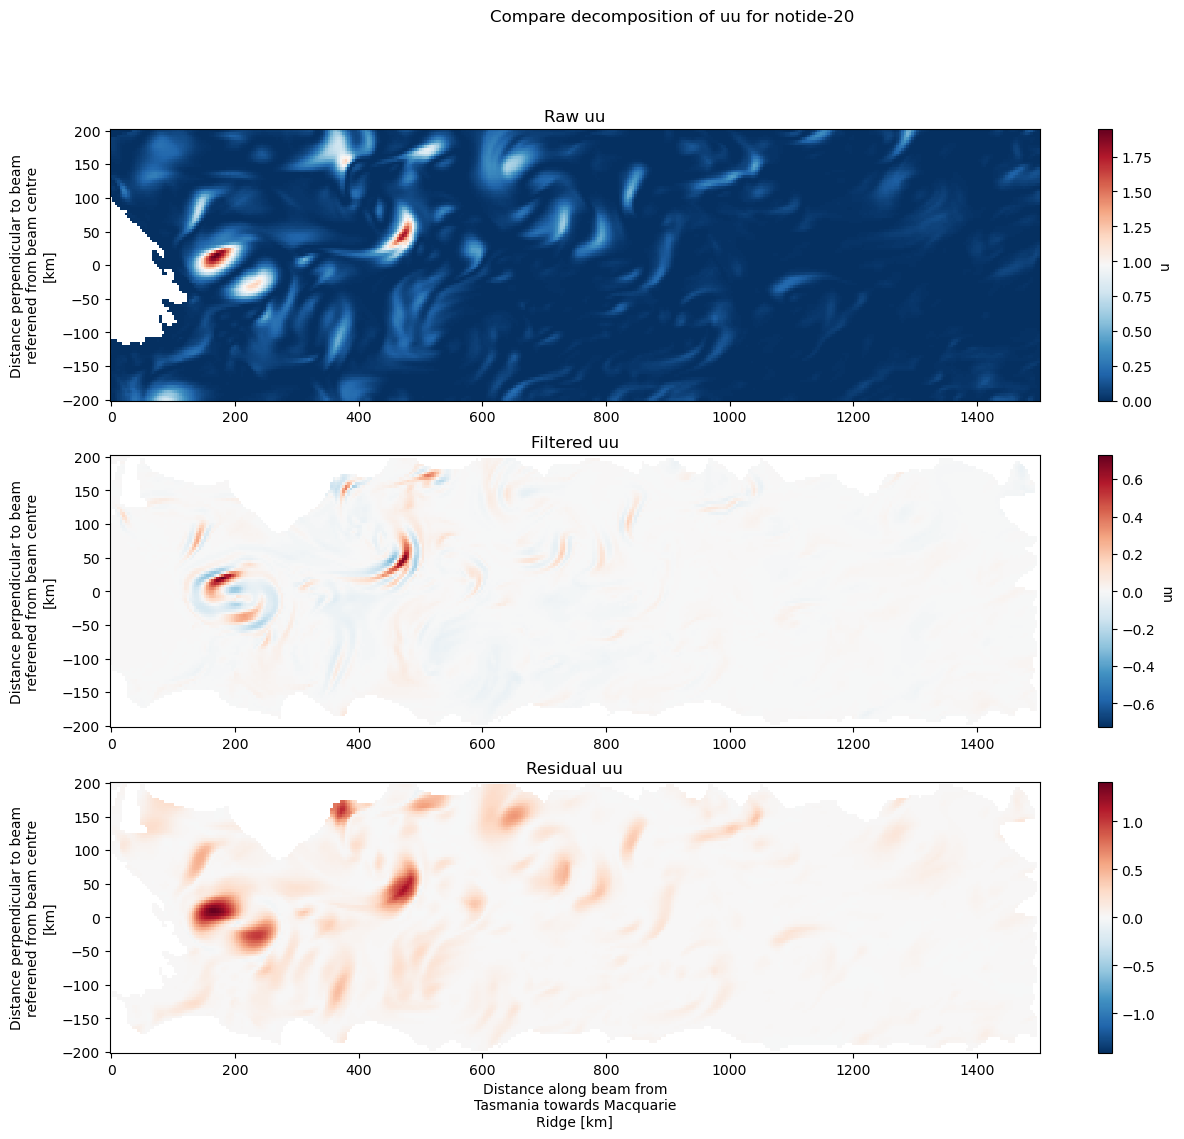

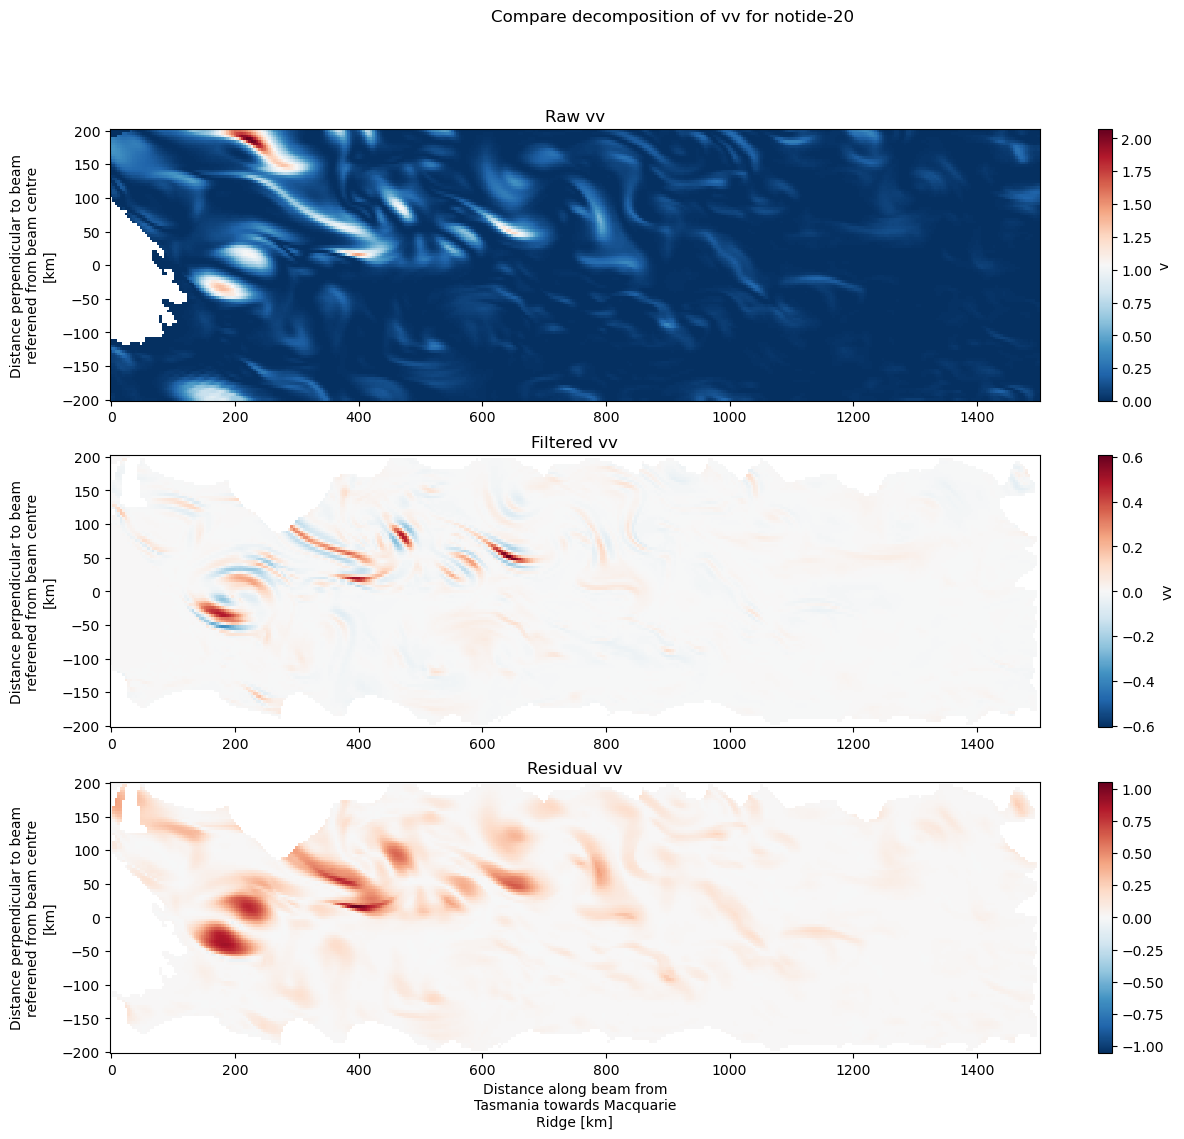

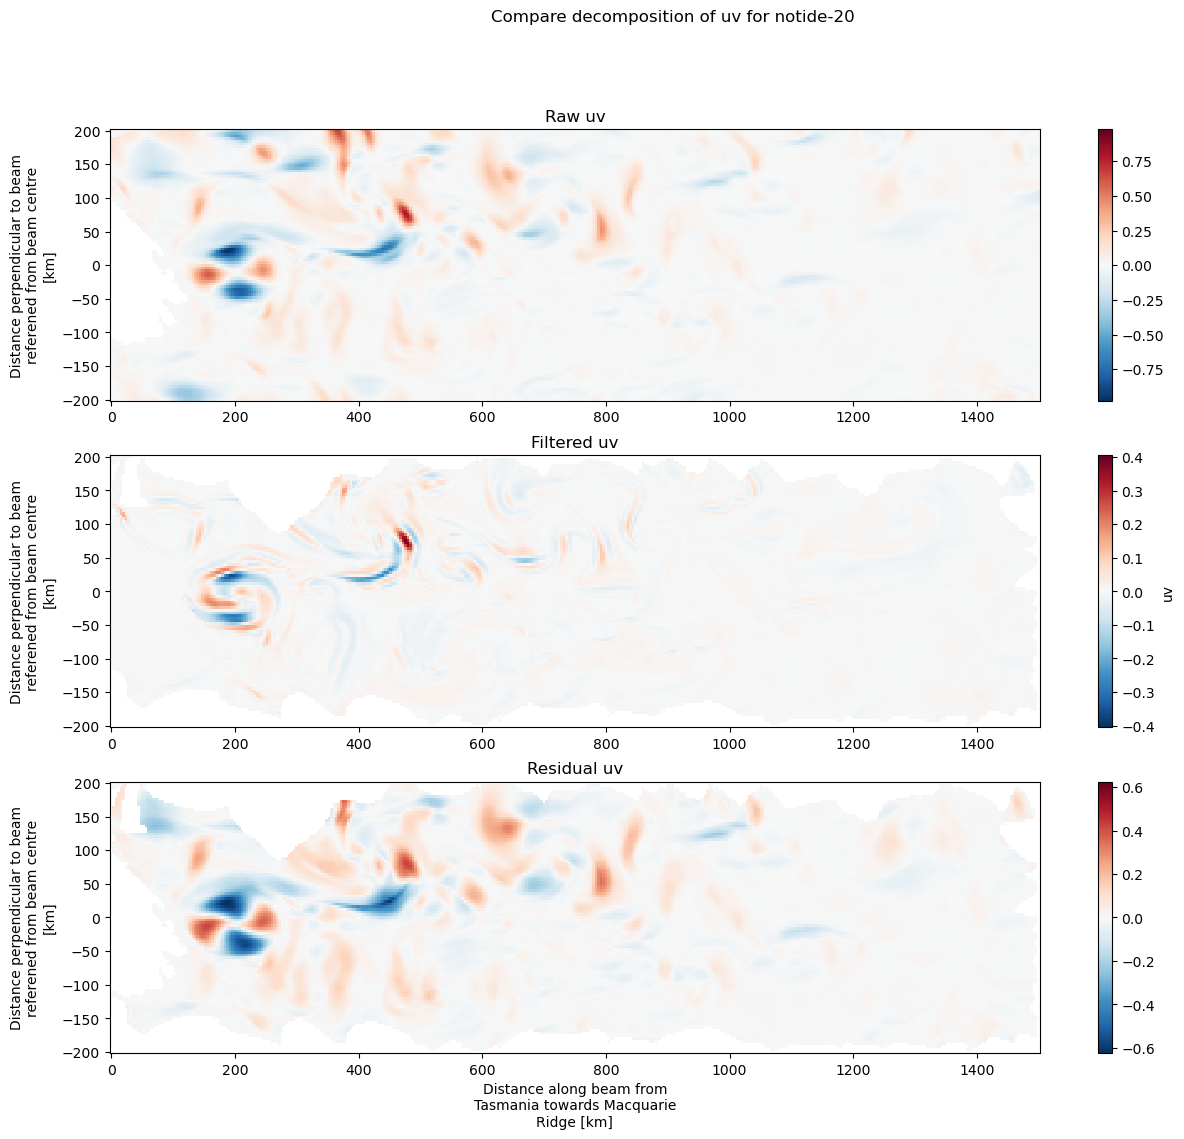

In [8]:
def compare_components(raw,filtered,field,expt):
    """
    Plot the raw field, the highpassed field and the residual (lowpassed) field
    """

    fig,ax = plt.subplots(3,figsize = (15,12))
    raw.plot(ax = ax[0],cmap = "RdBu_r")
    filtered.plot(ax = ax[1],cmap = "RdBu_r")
    (raw - filtered).plot(ax = ax[2],cmap = "RdBu_r")
    ax[0].set_title(f"Raw {field}")
    ax[1].set_title(f"Filtered {field}")
    ax[2].set_title(f"Residual {field}")
    ax[0].set_xlabel("")
    ax[1].set_xlabel("")

    fig.suptitle(f"Compare decomposition of {field} for {expt}")

    return fig


outpath = f"/g/data/nm03/ab8992/postprocessed/full-20/lfiltered/20hr_cutoff"
tide_filtered = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).isel(time = 0)

outpath = f"/g/data/nm03/ab8992/postprocessed/notide-20/lfiltered/20hr_cutoff"
notide_filtered = xr.open_mfdataset(outpath + "/*.nc",decode_times = False).isel(time = 0)

expt = "full-20"
fig = compare_components(rawdata_tide.u,tide_filtered.u,"u",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/u_lagrange_decomposition.png")
fig = compare_components(rawdata_tide.v,tide_filtered.v,"v",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/v_lagrange_decomposition.png")

fig = compare_components((rawdata_tide.u)**2,tide_filtered.uu,"uu",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/uu_lagrange_decomposition.png")

fig = compare_components((rawdata_tide.v)**2,tide_filtered.vv,"vv",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/vv_lagrange_decomposition.png")

fig = compare_components((rawdata_tide.u*rawdata_tide.v),tide_filtered.uv,"uv",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/uv_lagrange_decomposition.png")

expt = "notide-20"
fig = compare_components(rawdata_notide.u,notide_filtered.u,"u",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/u_lagrange_decomposition.png")
fig = compare_components(rawdata_notide.v,notide_filtered.v,"v",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/v_lagrange_decomposition.png")

fig = compare_components((rawdata_notide.u)**2,notide_filtered.uu,"uu",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/uu_lagrange_decomposition.png")

fig = compare_components((rawdata_notide.v)**2,notide_filtered.vv,"vv",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/vv_lagrange_decomposition.png")

fig = compare_components((rawdata_notide.u*rawdata_notide.v),notide_filtered.uv,"uv",expt)
fig.savefig(f"/g/data/v45/ab8992/dropbox/tasman-tides/{expt}/uv_lagrange_decomposition.png")

In [16]:
total_advection_time = 96 * 3600 # seconds
max_displacement = 100000 # m
average_speed = max_displacement / total_advection_time
average_speed

0.28935185185185186